In [15]:
import numpy as np
from matplotlib import pyplot as plt
from shapely.geometry import box
from shapely.ops import unary_union
from shapely.affinity import translate
from find_shifts import get_files, get_images
import cv2
%matplotlib widget

In [55]:
def phase_correlation(a, b):
    G_a = np.fft.fft2(a)
    G_b = np.fft.fft2(b)
    conj_b = np.ma.conjugate(G_b)
    R = G_a*conj_b
    R /= np.absolute(R)
    r = np.fft.ifft2(R).real
    return r

In [71]:
image0 = image_data[0]
image1 = image_data[1]

In [80]:
rgb_weights = [0.2989, 0.5870, 0.1140]
imageg0 = np.dot(image0, rgb_weights)
imageg1 = np.dot(image1, rgb_weights)
corrimg = phase_correlation(imageg0, imageg1)

shift = np.array(np.unravel_index(corrimg.argmax(), corrimg.shape))[:2]
shift

array([  2, 529], dtype=int64)

In [116]:
polys = []

# image0 at upper left of image (origin)
ul0 = 0,0
lr0 = image0.shape[:2]
polys.append(box(*ul0, *lr0))

# image1 shifted to its location
ul1 = shift
lr1 = image1.shape[:2] + shift
polys.append(box(*ul1, *lr1))

In [144]:
# union and envelope polygons to get the shape of the overall destination image
boundary = unary_union(polys)
e = boundary.envelope
# b is the boundary of the evelope of the union of all the polygons- the smallest enclosing shape.
b = e.bounds
b

(0.0, 0.0, 962.0, 1809.0)

In [133]:
counts = np.zeros((int(b[2]), int(b[3]), 3), dtype=np.uint16)
back = np.zeros((int(b[2]), int(b[3]), 3), dtype=np.float64)

In [146]:
counts[ul0[0]:ul0[0]+image0.shape[0],ul0[1]:ul0[1]+image0.shape[1]] += 1
counts[ul1[0]:ul1[0]+image1.shape[0],ul1[1]:ul1[1]+image1.shape[1]] += 1
back[ul0[0]:ul0[0]+image0.shape[0],ul0[1]:ul0[1]+image0.shape[1]] += image0
back[ul1[0]:ul1[0]+image1.shape[0],ul1[1]:ul1[1]+image1.shape[1]] += image1

In [196]:
i0 = np.zeros((int(b[2]), int(b[3]), 3), dtype=np.float64)
i0[ul0[0]:ul0[0]+image0.shape[0],ul0[1]:ul0[1]+image0.shape[1]] = image0

i1 = np.zeros((int(b[2]), int(b[3]), 3), dtype=np.float64)
i1[ul1[0]:ul1[0]+image1.shape[0],ul1[1]:ul1[1]+image1.shape[1]] = image1

bounds = polys[0].intersection(polys[1]).exterior.bounds


m0 = np.full((int(b[2]), int(b[3]), 3), True)
m0[ul0[0]:ul0[0]+image0.shape[0],ul0[1]:ul0[1]+image0.shape[1]] = False
mask0 = np.ma.masked_array(i0, m0)


m1 = np.full((int(b[2]), int(b[3]), 3), True)
m1[ul1[0]:ul1[0]+image1.shape[0],ul1[1]:ul1[1]+image1.shape[1]] = False
mask1 = np.ma.masked_array(i1, m1)


d = np.sqrt(np.sum(np.square(np.subtract(mask1,mask0))))
print(d)
#plt.imshow(d.astype(np.uint8))
#plt.show()

29094.39595523509


In [85]:
scaled = (back/counts).astype(np.uint8)

C:\Users\dek\AppData\Local\Temp\ipykernel_16212\1254128157.py:1: RuntimeWarning: invalid value encountered in true_divide
  scaled = (back/counts).astype(np.uint8)


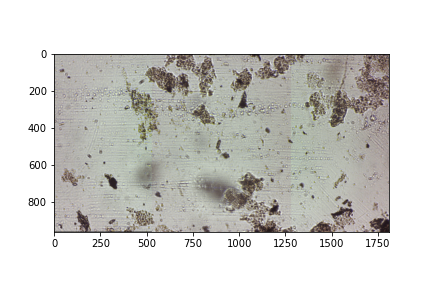

In [86]:
plt.imshow(scaled)
plt.show()